Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

Возьмите датасет EMNIST из torchvision
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.
Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
Повторите пункты 2 и 3 для всех указанных вариантов моделей.
Формат сдачи работы
Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите зачёт.

Задание считается выполненным, если:

вы обучили каждую модель до некоторого улучшения качества
составлена таблица обучения для сравнения
Задание будет отправлено на доработку, если:

использованы не все типы моделей
не составлена сводная таблица с результатами

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
import torch.utils.data as data_utils
import torchvision as tv
from torchsummary import summary
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [4]:
import inspect
import pickle
import os
import sys
base_dir = '/content/drive/MyDrive/tmp/'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [5]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [6]:
def train(net_name, net, train_iter, test_iter, trainer, num_epochs):
    Loss_train_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum') # используем категорийную кроссэнтропию и суммируем ошибки - чтобы сильнее их выделить
    net.train() # переключаем сеть в режим обучения
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device)) # считаем аккураси на тестовых данных
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        Loss_train_list.append(train_l_sum / n)
        Accuracy_train_list.append(train_acc_sum / n)
        Accuracy_test_list.append(test_acc)

    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    x3 = range(0, num_epochs)
    y1 = Loss_train_list
    y2 = Accuracy_train_list
    y3 = Accuracy_test_list
    #print(f'')
    fig, ax = plt.subplots(3,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    fig.suptitle('loss & accuracy')
    ax[0].plot(x1, y1, 'o-')
    ax[0].set_xlabel('train loss vs. epoches')
    ax[0].set_ylabel('train loss')
    ax[1].plot(x2, y2, '.-')
    ax[1].set_xlabel('train accuracy vs. epoches')
    ax[1].set_ylabel('train accuracy')
    ax[2].plot(x3, y3, '.-')
    ax[2].set_xlabel('test accuracy vs. epoches')
    ax[2].set_ylabel('test accuracy')
    plt.show()
    path_png = "/content/drive/MyDrive/tmp/" + net_name + ".png"
    fig.savefig(path_png, format='png')

    save_pickle(Loss_train_list,net_name + '_' + 'Loss_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_train_list,net_name + '_' + 'Accuracy_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_test_list,net_name + '_' + 'Accuracy_test_list' + '.pickle',base_dir)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DataSet

EMNIST ByClass: 697 932 characters. 62 unbalanced classes.

EMNIST ByMerge: 697 932 characters. 47 unbalanced classes.

EMNIST Balanced: 112 800 characters. 47 balanced classes.

EMNIST Letters: 124 800 characters. 26 balanced classes.

EMNIST Digits: 240 000 characters. 10 balanced classes.

EMNIST MNIST: 60 000 characters. 10 balanced classes.

<font color=green size=3>
Видим, что полных набора 3.
<br>
Из них:
<br>
<br>
EMNIST Balanced - специально сбалансированный, для облегчения обучения.
<br>
EMNIST ByClass - самый полный  и несбалансированный.
<br>
Будем использовать и тот и другой, чтобы посмотреть на разницу для обучения.
<br>
</font>

In [8]:
BATCH_SIZE = 256
indices = torch.arange(112800)

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3), # предобученные модели работают с 3х канальными рисунками, поэтому искусственно делаем из одного три канала
    tv.transforms.Resize((224, 224)), # трансформируем наши изображения до требуемого размера
    tv.transforms.ToTensor()
])
train_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=True, transform=transoforms, download=True)
test_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=False, transform=transoforms, download=True)

train_dataset_bc_min = data_utils.Subset(train_dataset_bc, indices)
test_dataset_bc_min = data_utils.Subset(test_dataset_bc, indices)
train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc_min, batch_size=BATCH_SIZE)
test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее
# 112800 ограничили количеством в сбалансированном датасете

#train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc, batch_size=BATCH_SIZE)
#test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc, batch_size=BATCH_SIZE)

#############################################3

train_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=True, transform=transoforms, download=True)
test_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=False, transform=transoforms, download=True)

#train_dataset_bl_min = data_utils.Subset(train_dataset_bl, indices)
#test_dataset_bl_min = data_utils.Subset(test_dataset_bl, indices)
#train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl_min, batch_size=BATCH_SIZE)
#test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее


train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl, batch_size=BATCH_SIZE)
test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:09<00:00, 56268514.11it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


<font color=green size=3>
VGG16 feature extraction  
<br>
EMNIST ByClass
<br>
</font>

In [9]:
model_name = 'model_vgg16_bc'
model_vgg16_bc = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s] 


In [10]:
model_vgg16_bc = model_vgg16_bc.to(device)

In [11]:
print(model_vgg16_bc)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
summary(model_vgg16_bc.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# Убираем требование градиента:
for param in model_vgg16_bc.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [14]:
model_vgg16_bc.classifier[6] = nn.Linear(in_features=4096, out_features=62).to(device)

In [15]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_vgg16_bc.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Step 0. time since epoch: 2.199. Train acc: 0.020. Train Loss: 4.231
Step 10. time since epoch: 18.686. Train acc: 0.130. Train Loss: 3.607
Step 20. time since epoch: 34.909. Train acc: 0.215. Train Loss: 3.306
Step 30. time since epoch: 51.293. Train acc: 0.269. Train Loss: 3.106
Step 40. time since epoch: 67.970. Train acc: 0.303. Train Loss: 2.946
Step 50. time since epoch: 84.870. Train acc: 0.332. Train Loss: 2.814
Step 60. time since epoch: 101.807. Train acc: 0.357. Train Loss: 2.703
Step 70. time since epoch: 120.775. Train acc: 0.379. Train Loss: 2.602
Step 80. time since epoch: 137.860. Train acc: 0.394. Train Loss: 2.520
Step 90. time since epoch: 155.107. Train acc: 0.409. Train Loss: 2.446
Step 100. time since epoch: 172.643. Train acc: 0.419. Train Loss: 2.386
Step 110. time since epoch: 190.960. Train acc: 0.430. Train Loss: 2.333
Step 120. time since epoch: 208.911. Train acc: 0.440. Train Loss: 2.281
Step 130. time since epoch: 226.946. Train acc: 0.450. Train Loss: 2.

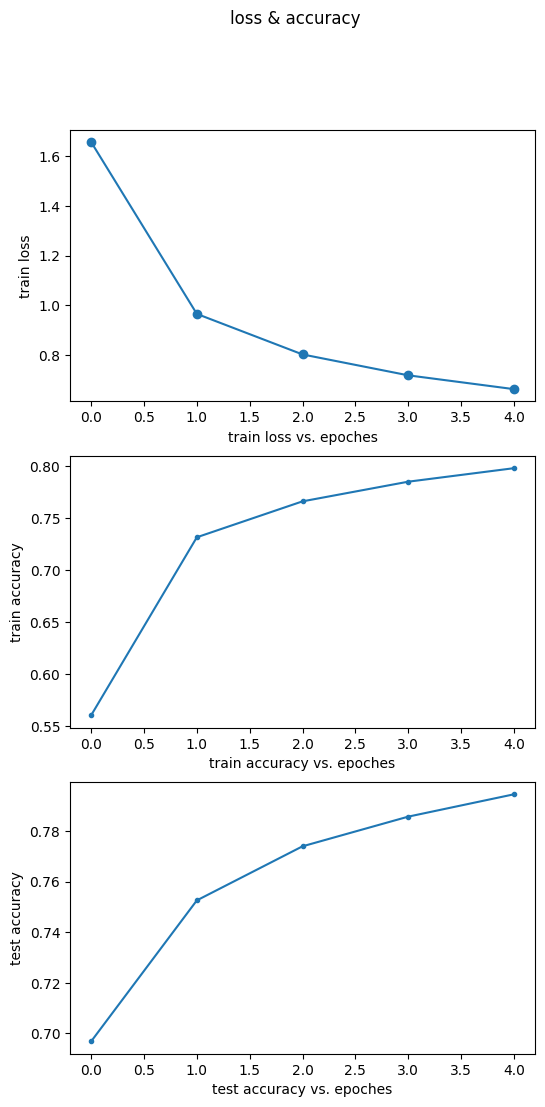

saved "model_vgg16_bc_Loss_train_list.pickle" (61.0 B).
saved "model_vgg16_bc_Accuracy_train_list.pickle" (61.0 B).
saved "model_vgg16_bc_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 1h 48min 32s, sys: 6min 31s, total: 1h 55min 4s
Wall time: 1h 55min 45s


In [16]:
%%time
lr, num_epochs = 0.0007, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_vgg16_bc, train_iter_bc, test_iter_bc, trainer, num_epochs)

In [17]:
path_model = base_dir + model_name + '.pt'
torch.save(model_vgg16_bc.state_dict(), path_model)

In [18]:
torch.cuda.empty_cache()

<font color=green size=3>
VGG16 feature extraction  
<br>
EMNIST Balanced
<br>
</font>

In [9]:
model_name = 'model_vgg16_bl'
model_vgg16_bl = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.8MB/s]


In [10]:
model_vgg16_bl = model_vgg16_bl.to(device)

In [11]:
print(model_vgg16_bl)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
summary(model_vgg16_bl.to(device), input_size=(3, 224, 224)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# Убираем требование градиента:
for param in model_vgg16_bl.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [15]:
model_vgg16_bl.classifier[6] = nn.Linear(in_features=4096, out_features=47).to(device)

In [16]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_vgg16_bl.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Step 0. time since epoch: 1.869. Train acc: 0.012. Train Loss: 3.911
Step 10. time since epoch: 18.192. Train acc: 0.094. Train Loss: 3.629
Step 20. time since epoch: 33.961. Train acc: 0.164. Train Loss: 3.384
Step 30. time since epoch: 49.948. Train acc: 0.226. Train Loss: 3.174
Step 40. time since epoch: 65.993. Train acc: 0.266. Train Loss: 3.019
Step 50. time since epoch: 82.529. Train acc: 0.296. Train Loss: 2.887
Step 60. time since epoch: 99.349. Train acc: 0.316. Train Loss: 2.782
Step 70. time since epoch: 116.646. Train acc: 0.335. Train Loss: 2.689
Step 80. time since epoch: 133.652. Train acc: 0.352. Train Loss: 2.610
Step 90. time since epoch: 150.855. Train acc: 0.367. Train Loss: 2.536
Step 100. time since epoch: 168.234. Train acc: 0.382. Train Loss: 2.471
Step 110. time since epoch: 185.587. Train acc: 0.393. Train Loss: 2.415
Step 120. time since epoch: 202.581. Train acc: 0.404. Train Loss: 2.364
Step 130. time since epoch: 219.625. Train acc: 0.413. Train Loss: 2.3

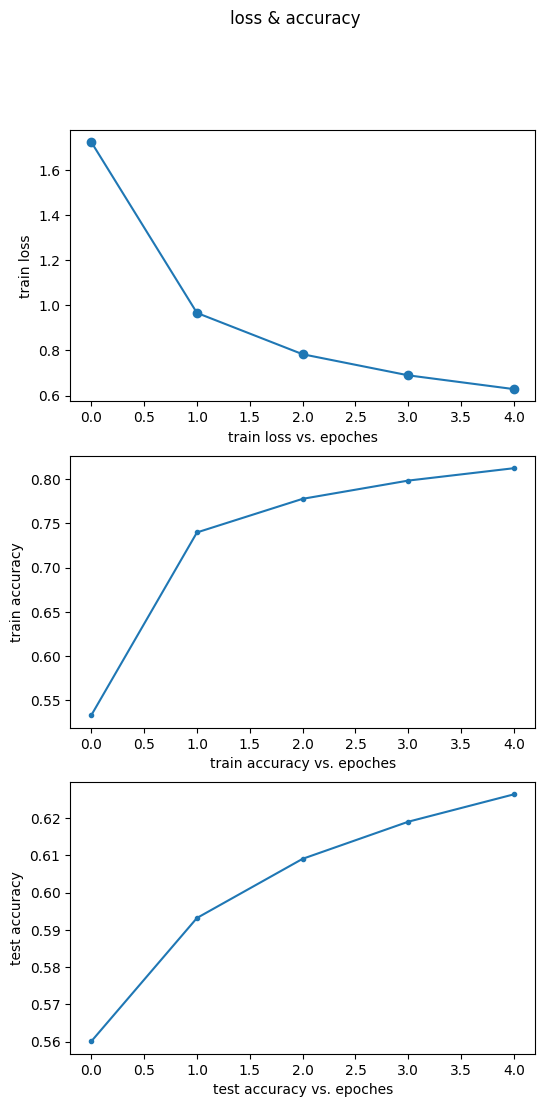

saved "model_vgg16_bl_Loss_train_list.pickle" (61.0 B).
saved "model_vgg16_bl_Accuracy_train_list.pickle" (61.0 B).
saved "model_vgg16_bl_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 1h 46min 1s, sys: 6min 18s, total: 1h 52min 19s
Wall time: 1h 52min 50s


In [17]:
%%time
lr, num_epochs = 0.0007, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train(model_name, model_vgg16_bl, train_iter_bl, test_iter_bc, trainer, num_epochs)

In [18]:
path_model = base_dir + model_name + '.pt'
torch.save(model_vgg16_bl.state_dict(), path_model)

In [28]:
torch.cuda.empty_cache()

<font color=green size=3>
Это шаблон примечания
<br>
<br>
</font>